In [1]:
import os
import utils
import pymzn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', font_scale=1.5)
from matplotlib.patches import Patch

In [2]:
# get multipliers
ls = []
instance_folder = "../0-first-submission/use-case-1"
for instance in os.listdir(instance_folder):
    if ".dzn" not in instance:
        continue
    data = pymzn.dzn2dict(f"{instance_folder}/{instance}")
    data["instance"] = instance
    ls.append(data)
instance_data = pd.DataFrame(ls)[["instance",'upper_bound_integer_objective',
       'mult_factor_total_runtime', 'mult_factor_finished_toolate',
       'mult_factor_total_setuptimes', 'mult_factor_total_setupcosts',]]
instance_data["instance_number"] = instance_data.apply(lambda row: utils.get_instance_code(row["instance"]),axis=1)
instance_data.head()

,instance,upper_bound_integer_objective,mult_factor_total_runtime,mult_factor_finished_toolate,mult_factor_total_setuptimes,mult_factor_total_setupcosts,instance_number
0,50RandomOvenSchedulingInstance-n50-k2-a5-WithI...,2772000,44,52800,0,48,50
1,22RandomOvenSchedulingInstance-n25-k2-a2-WithI...,15750,4,600,0,2,22
2,47RandomOvenSchedulingInstance-n50-k2-a5-WithI...,135712500,2200,2585000,0,1175,47
3,49RandomOvenSchedulingInstance-n50-k2-a5-WithI...,787500,12,15000,0,6,49
4,43RandomOvenSchedulingInstance-n50-k2-a2-WithI...,31500,4,600,0,6,43


In [3]:
# upload upper bounds, use the instances for the weights
upper_b = pd.read_csv("data/upper-bounds.csv",sep=";")
upper_b = pd.merge(upper_b,instance_data,on="instance_number")
upper_b["my_obj"] = upper_b.apply(lambda row: utils.calc_complete_objective(
    row["upper_bound_integer_objective"],
    row["total running time"], row["mult_factor_total_runtime"],
    row["total setup costs"], row["mult_factor_total_setupcosts"],
    row["number of too late jobs"], row["mult_factor_finished_toolate"]
),axis=1)

upper_b["my_obj_integer"] = upper_b.apply(lambda row: utils.calc_complete_objective_integer(
    row["upper_bound_integer_objective"],
    row["total running time"], row["mult_factor_total_runtime"],
    row["total setup costs"], row["mult_factor_total_setupcosts"],
    row["number of too late jobs"], row["mult_factor_finished_toolate"]
),axis=1)
upper_b.head()

,config,instance_x,run,solutionCosts,optimal,feasible,totalTime,improvement of runtime over runtime without batching,average number of jobs per batch,normalised objective bound,...,instance_number,objective,instance_y,upper_bound_integer_objective,mult_factor_total_runtime,mult_factor_finished_toolate,mult_factor_total_setuptimes,mult_factor_total_setupcosts,my_obj,my_obj_integer
0,~/oven-scheduling-problem/solution-methods/lin...,../../instances/01RandomOvenSchedulingInstance...,1,0.893206,-1,1,-1,-1,-1,-1,...,1,combined objective,01RandomOvenSchedulingInstance-n10-k2-a2-WithI...,31500,24,3000,0,10,0.893206,28136
1,~/oven-scheduling-problem/solution-methods/lin...,../../instances/10RandomOvenSchedulingInstance...,1,0.981395,-1,1,-1,-1,-1,-1,...,10,combined objective,10RandomOvenSchedulingInstance-n10-k2-a5-WithI...,1680000,100,160000,0,64,0.981395,1648744
2,~/oven-scheduling-problem/solution-methods/lin...,../../instances/100RandomOvenSchedulingInstanc...,1,0.955111,-1,1,-1,-1,-1,-1,...,100,combined objective,100RandomOvenSchedulingInstance-n250-k5-a5--22...,157500,4,600,0,2,0.955111,150430
3,~/oven-scheduling-problem/solution-methods/lin...,../../instances/101RandomOvenSchedulingInstanc...,1,0.966102,-1,1,-1,-1,-1,-1,...,101,combined objective,101RandomOvenSchedulingInstance-n500-k2-a2--23...,315000,4,600,0,3,0.966102,304322
4,~/oven-scheduling-problem/solution-methods/lin...,../../instances/102RandomOvenSchedulingInstanc...,1,0.963038,-1,1,-1,-1,-1,-1,...,102,combined objective,102RandomOvenSchedulingInstance-n500-k2-a2--23...,337365000,476,642600,0,306,0.963038,324895398


In [4]:
# select bounds from theory
lower_b = pd.read_csv("data/theoretical-lower-bounds.csv")\
    .rename(columns={
        "normalised objective bound":"LB_objNormalized",
    })[["instance_number","LB_objNormalized"]]
lower_b.head()

,instance_number,LB_objNormalized
0,1,0.694222
1,2,0.974127
2,3,0.216508
3,4,0.206667
4,5,0.018632


In [5]:
df = pd.merge(upper_b,lower_b,on="instance_number")
df["gap"] = df.apply(lambda row: utils.perc_gap(row["my_obj"],row["LB_objNormalized"]),axis=1)
df["size"] = df.apply(lambda row: utils.get_size(instance_number=row["instance_number"]),axis=1)
df[["instance_number","LB_objNormalized","my_obj","gap","size"]]

,instance_number,LB_objNormalized,my_obj,gap,size
0,1,0.694222,0.893206,22.28,small
1,10,0.598445,0.981395,39.02,small
2,100,0.555060,0.955111,41.89,large
3,101,0.663670,0.966102,31.30,large
4,102,0.957231,0.963038,0.60,large
...,...,...,...,...,...
115,95,0.945505,0.982298,3.75,large
116,96,0.972635,0.982019,0.96,large
117,97,0.341194,0.717702,52.46,large
118,98,0.959562,0.971280,1.21,large


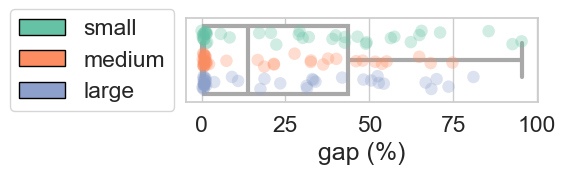

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 2))
size_order = ["small", "medium", "large"]
palette = sns.color_palette("Set2", n_colors=len(size_order))
sns.boxplot(x="gap", data=df, ax=ax1, linecolor="darkgray", color="white", linewidth=3)
sns.stripplot(x="gap", data=df, ax=ax1, palette=palette, alpha=0.3, jitter=0.25, size=9,dodge=True,hue="size", hue_order=size_order)
ax1.set_title(None)
ax1.set_ylabel(None)
ax1.set_xlabel('gap (%)')
handles = [Patch(facecolor=palette[i], edgecolor="black", label=str(s))
           for i, s in enumerate(size_order)]
leg = ax1.legend(
    handles=handles, title=None, frameon=True,
    loc="center right",bbox_to_anchor=(0, 0.5),
    ncols=1
)
plt.tight_layout()
fig.savefig("figures/fig-upper-bounds.pdf",bbox_inches='tight')
plt.show()

In [7]:
df.query("gap < 10.0").shape

(59, 29)

In [8]:
df.query("gap < 1.0").shape

(37, 29)

In [9]:
df.query("gap > 1.0 and gap < 10.0").shape

(22, 29)